In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
df_not_prep = pd.read_csv('vienna_sights_adjusted.csv', sep=',')
#angepasster Dataframe -> einige Sights haben keine Koordinaten gehabt, oder diese sind in der falschen Spalte gestanden. Für die Aufgabe
#sind die Spalte name und die Koordinaten von Bedeutung. Rest kann entfernt werden.

In [3]:
df = df_not_prep.filter(items=['name', 'latitude', 'longitude'])

In [4]:
#create matrix for DBScan
coords = df.as_matrix(columns=['latitude', 'longitude'])

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Erdradius und epsilon setzen. Zuerst epsilion nach Angabe auf 350 Meter setzen. Später Epsilon verändern.

In [5]:
kms_per_radian = 6371.0088

In [6]:
# laut Angabe 350 Meter
#epsilon = 0.35 / kms_per_radian
# Versuch Angabe 500 Meter
#epsilon = 0.5 / kms_per_radian
#Versuch Angabe 600 Meter
epsilon = 0.6 / kms_per_radian

In [7]:
db = DBSCAN(eps=epsilon, min_samples=4, algorithm='auto', metric='haversine').fit(np.radians(coords))

In [8]:
cluster_labels = db.labels_

In [9]:
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_ = list(cluster_labels).count(-1)

In [10]:
print('Estimated number of clusters: %d' % num_clusters)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 40


In [11]:
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

Zwei Funktionen definieren für Centroid bekommen und die Namen der Sights bekommen.

In [12]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [13]:
def get_name(cluster):
    print('=========================== CLUSTER START ===========================')
    lats, lons = zip(*cluster)
    for l in lats:
        for index, row in df.iterrows():
            if(l == row['latitude']):
                print(row['name'])
    print('=========================== CLUSTER END ===========================')


clusters.map(get_name)

=========================== CLUSTER START ===========================
Leopold Museum
Mozarthaus Vienna 'Figarohaus'
Naturhistorisches Museum
Schatzkammer
Secession
Sisi Museum
Votivkirche
Wien Museum Karlsplatz
Schmetterlinghaus
Spanische Hofreitschule
Wiener Staatsoper
Zentralfriedhof (Ehrengräber)
Augustinerkirche
Donauturm
Kirche am Steinhof
=========================== CLUSTER END ===========================
=========================== CLUSTER START ===========================
MUMOK Museum Moderner Kunst Stiftung Ludwig Wien
Österreichische Nationalbibliothek
Musikverein
Sigmund Freud Museum
Albertina
Islamisches Zentrum Wien / Moschee
Karlskirche
=========================== CLUSTER END ===========================
=========================== CLUSTER START ===========================
Technisches Museum
Schönbrunn - Irrgarten
Ankeruhr
Palmenhaus
=========================== CLUSTER END ===========================


0    None
1    None
2    None
dtype: object

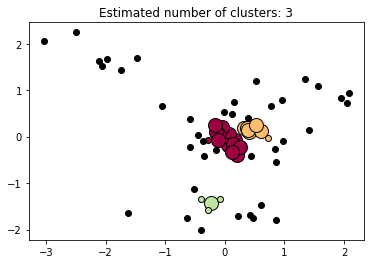

In [14]:
# Black removed and is used for noise instead.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
unique_labels = set(cluster_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (cluster_labels == k)

    X = StandardScaler().fit_transform(np.radians(coords))
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % num_clusters)
plt.show()